In [3]:
import sys
sys.path.append("/home/ly/workspace/mmsa")
seed = 1938
import numpy as np
import torch
from torch import nn
from torch import optim

np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
from models.lymodel5 import *
from utils.train import *
from typing import *
from collections import Counter
from utils.load_yelp import *
from utils.dataset import *
from utils.train import *
from utils.train import *

In [4]:
config

{'task': 'CLS',
 'embedding_dim': 100,
 'embedding': None,
 'freeze_embedding': True,
 'text_hidden_size': 100,
 'text_layers': 1,
 'max_tokens': 512,
 'uniform_bound': 0.1,
 'img_input_size': 2048,
 'img_encoder_layers': 1,
 'attention_nhead': 4,
 'fusion_nheads': 4,
 'dropout': 0.1,
 'output_size': 5,
 'bias_init': 1.0}

In [3]:
# torch.cuda.set_device(1)

In [5]:
batch_size = 64
workers = 4
train_set, valid_set, test_set= load_glove_data(split811data, config)
train_loader, valid_loader, test_loader = get_loader(batch_size, workers, get_collate_fn(config), train_set, valid_set, test_set)
model = Model(config).cuda()
loss = nn.CrossEntropyLoss()
get_parameter_number(model), loss

/home/ly/miniconda3/envs/torch1.6.0/lib/python3.7/site-packages/torch/nn/modules/rnn.py:60: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


({'Total': 5297605, 'Trainable': 1014205}, CrossEntropyLoss())

In [6]:
%%time
y_true, y_pred, _loss = predict(model, valid_loader, loss)
evalute(y_true, y_pred), Counter(y_pred)

CPU times: user 3.4 s, sys: 2.17 s, total: 5.57 s
Wall time: 9.5 s


((0.1943566591422122, 0.06332845971672156), Counter({4: 4429, 1: 1}))

In [7]:
%%time
_interval = 5
lr = 1e-3
epoches = 50
stoping_step = 10
optimizer = get_regal_optimizer(model, optim.AdamW, lr)

viz = get_Visdom()
batch_loss_drawer = VisdomScalar(viz, f"batch_loss interval:{_interval}")
epoch_loss_drawer = VisdomScalar(viz, f"Train and valid loss", 2)
acc_drawer = VisdomScalar(viz, "Train and valid accuracy", 2)
text_writer = VisdomTextWriter(viz, "Training")

batch_loss = []
train_loss = []
valid_loss = []
train_acc = []
valid_acc = []

res, model = train_visdom_v2(model, optimizer, loss, viz, train_loader,
                          valid_loader, epoches, batch_loss, batch_loss_drawer,
                          train_loss, valid_loss, epoch_loss_drawer,
                          train_acc, valid_acc, acc_drawer, text_writer,
                         _interval=_interval, early_stop=stoping_step)

Setting up a new session...
No 1 epoch: 554it [01:28,  6.29it/s]
No 2 epoch: 554it [01:29,  6.17it/s]
No 3 epoch: 554it [01:29,  6.20it/s]
No 4 epoch: 554it [01:29,  6.17it/s]
No 5 epoch: 554it [01:29,  6.22it/s]
No 6 epoch: 554it [01:29,  6.18it/s]
No 7 epoch: 554it [01:29,  6.20it/s]
No 8 epoch: 554it [01:28,  6.26it/s]
No 9 epoch: 554it [01:30,  6.13it/s]
No 10 epoch: 554it [01:30,  6.11it/s]
No 11 epoch: 554it [01:30,  6.15it/s]
No 12 epoch: 554it [01:30,  6.10it/s]
No 13 epoch: 554it [01:31,  6.07it/s]
No 14 epoch: 554it [01:29,  6.17it/s]
No 15 epoch: 554it [01:31,  6.06it/s]
No 16 epoch: 554it [01:28,  6.24it/s]


CPU times: user 16min 15s, sys: 6min 25s, total: 22min 41s
Wall time: 26min 36s


In [8]:
res

{'min_valid_loss': 0.9049281890451505,
 'min_valid_loss_epoch': 6,
 'min_loss_train_acc': 0.5877838905346311,
 'min_valid_loss_train_loss': 0.934598438681593,
 'min_loss_valid_acc': 0.6058690744920994,
 'last_valid_acc': 0.582392776523702,
 'last_train_acc': 0.7912822683030046,
 'last_epoch': 16,
 'last_train_loss': 0.5077797283749937,
 'last_valid_loss': 1.3200453326072434}

In [9]:
eval_model(model, test_loader, loss)

/home/ly/miniconda3/envs/torch1.6.0/lib/python3.7/site-packages/torch/nn/modules/rnn.py:738: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /opt/conda/conda-bld/pytorch_1595629427478/work/aten/src/ATen/native/cudnn/RNN.cpp:1234.)
  self.num_layers, self.dropout, self.training, self.bidirectional)


((0.5988713318284424, 0.5998947798729796), 0.9108354908618109)

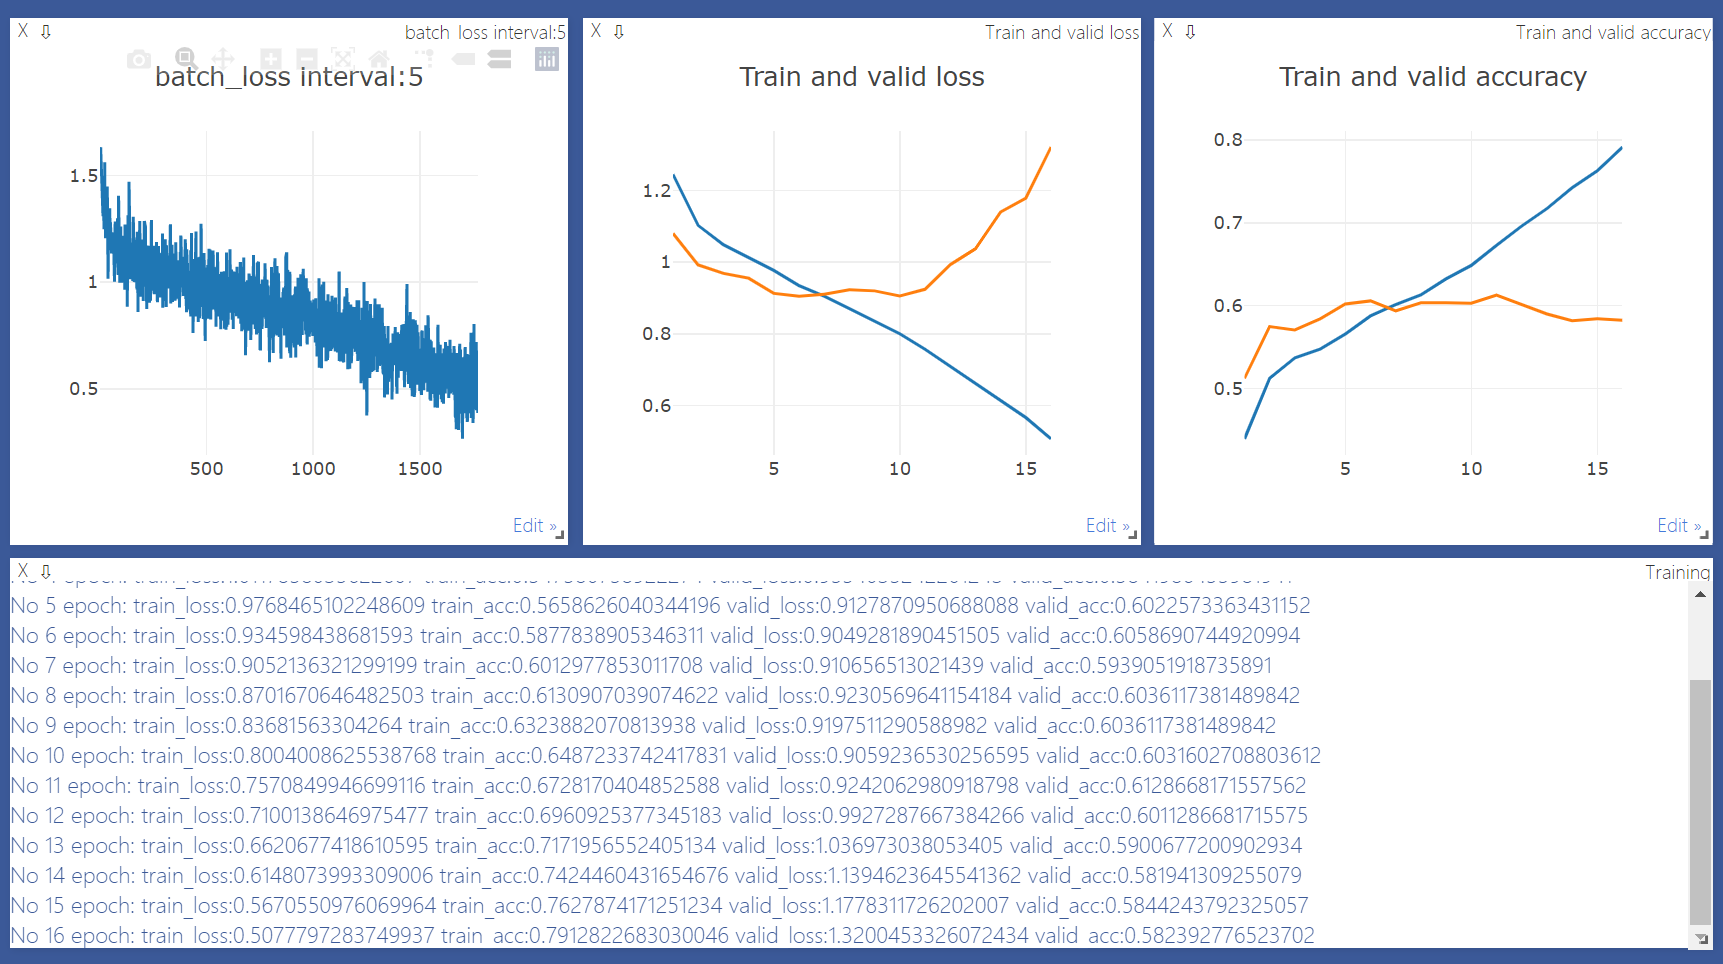